---
title: "Lecture 9: Rootfinding methods"
author: "Jamie Haddock"
format: 
    revealjs:
        output-file: Lecture9_slides
        slide-number: true
        chalkboard: 
            buttons: false
        preview-links: auto
        logo: figs/hmc.png
        css: input/slides.css
        incremental: true
        smaller: true
        code-fold: true
    html: 
        code-fold: true
    pdf:
        documentclass: article
        toc: true
        number-sections: true
        geometry:
          - top=1in
          - left=1in
          - bottom=1in
          - right=1in
format-links: false
jupyter: julia-1.9
filters: 
  - input/remove-pause.lua
execute:
  echo: true
  eval: true
---

# Rootfinding problems

*Many* problems in engineering, various sciences, data science, and machine learning can be rephrased as finding a root of a given function!  It is so important an archetypical problem that we study a variety of methods for this generic problem formulation, but you will see that many may be familiar from specific applications where they may go under different names.

## Rootfinding problem

::: {.callout-note icon=false}
## Definition: Rootfinding problem
Given a continuous function $\mathbf{f}$ of a variable input $\mathbf{v}$, the **rootfinding problem** is to find a real input $\mathbf{r}$, called a **root** such that $$\mathbf{f}(\mathbf{r}) = \mathbf{0}.$$
:::

. . .

In Calculus, you have likely already encountered such a problem.  In *optimization*, we often seek a *stationary point* of a given objective function as candidates for the maximizer or minimizer of a given function $L(\mathbf{x})$.  Mathematically, this is seeking $\mathbf{x}$ so that $$\nabla L(\mathbf{x}) = \mathbf{0}.$$

. . .

In this class, we'll focus on the case where the rootfinding problem is defined by continuous scalar function $f$ of a scalar variable; that is, we seek $r$ so that $$f(r) = 0.$$

## Conditioning, error, and residual

In the rootfinding problem, the data is the function $f$, and the result is a root.  How does the result change in response to perturbations in $f$?

[The perturbation to the function could be due to rounding in the evaluation of values of $f$, or evaluating $f$ may require computation via an inexact algorithm (sometimes evaluating relatively simple functions require complicated algorithms).  ]{.content-hidden when-format='revealjs' when-format='pptx'} 

. . .

Assum4 $f$ has at least one continous derivative near a roor $r$.  Suppose $f$ is perturbed to $\tilde{f}(x) = f(x) + \epsilon$ (constant perturbation).  As a result, the root (if it exists) will be perturbed to $\tilde{r} = r + \delta$ such that $\tilde{f}(\tilde{r}) = 0$.  We compute here an absolute condition number $\kappa_r$, which is the ratio $|\delta/\epsilon|$ as $\epsilon \rightarrow 0$.

. . .

Using Taylor's theorem, we have $$0 = \tilde{f}(\tilde{r}) = f(r + \delta) + \epsilon \approx f(r) + f'(r)\delta + \epsilon = f'(r)\delta + \epsilon.$$

::: {.callout-warning icon=false}
## Theorem: Condition number of rootfinding
If $f$ is differentiable at a root $r$, then the absolute condition number of $r$ with respect to constant changes in $f$ is $$\kappa_r = |f'(r)|^{-1}.$$  We say $\kappa_r = \infty$ if $f'(r) = 0$.  
:::

---

Let's see what this condition number looks like visually!

In [49]:
#| echo: false

using Plots

In [50]:
f = x -> (x-1)*(x-2);      # function of which we wish to find a root

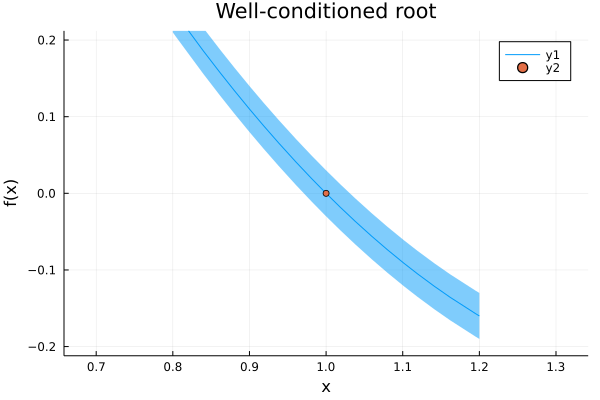

In [51]:
interval = [0.8, 1.2]
plot(f,interval...,ribbon=0.03, aspect_ratio=1, xlabel="x",yaxis=("f(x)",[-0.2,0.2]))
scatter!([1],[0],title="Well-conditioned root")

. . .

The possible values for the perturbed root lie within the intersection of the ribbon with the $x$-axis.  The width of this region is similar in length to the vertical thickness of the ribbon.

---

In [52]:
f = x -> (x-1)*(x-1.01);    #a new function for us to rootfind!

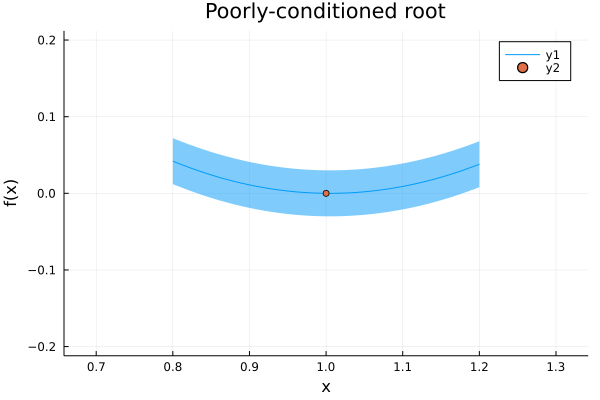

In [53]:
plot(f, interval...,ribbon=0.03,aspect_ratio=1, xlabel="x",yaxis=("f(x)",[-0.2,0.2]))
scatter!([1],[0],title="Poorly-conditioned root")

. . .

The bound on the constant perturbation to $f$ (the vertical width of the band) is the same as before, but now the potential displacement of the root (the horizontal width of the intersection of the band with the $x$-axis) is much wider!  In fact, the root could even cease to exist under possible perturbations.

---

If $|f'|$ is small at the root, it may not be possible to get a small error in a computed estimate of the root.  We can't measure this error, but, as usual, can measure the **residual**.

::: {.callout-note icon=false}
## Definition: Rootfinding residual
If $\tilde{r}$ approximates a root $r$ of function $f$, then the **residual** at $\tilde{r}$ is $f(\tilde{r})$.
:::

. . .

Define $g(x) = f(x) - f(\tilde{r})$ and note that $\tilde{r}$ is a root of $g$.  Next, note then that $f(\tilde{r}) = g(x) - f(x)$, so we see that the residual is the distance of $f$ to an exactly solved rootfinding problem.  This is the backward error!

. . .

::: {.callout-warning icon=false}
## Fact: 
The backward error in a root estimate is equal to the residual.
:::

. . .

To summarize -- we can't expect a small error in a root approximation if the condition number is large, but we can gauge the backward error from the residual!

# Fixed-point iteration

We typically employ iterative methods to approximate a solution to the rootfinding problem.  The first method relies on a reformulation of the rootfinding problem as a **fixed-point problem**.

## Fixed-point iterative method

::: {.callout-note icon=false}
## Definition: Fixed-point problem
Given a function $g$, the **fixed-point problem** is to find a value $p$, called a **fixed point**, such that $g(p) = p$.
:::

. . .

We may pass back and forth between equivalent fixed-point and rootfinding problems (meaning they have the same set of solutions).  

* Given a rootfinding problem defined by $f$, we can define $g(x) = x - f(x)$.  Note that a root $r$ satisfying $f(r) = 0$ is a fixed-point of $g$: $$g(r) = r - f(r) = r.$$  (There are many other possible reductions.)
* Given a fixed-point problem defined by $g$, we can define $f(x) = x - g(x)$.  Note that a fixed-point $p$ satisfying $g(p) = p$ is a root of $f$: $$f(p) = p - g(p) = p - p = 0.$$

## Algorithm

The reason that we are interested in transforming our problem to a fixed-point problem is that there is a very simple method for approximating a solution.  This method is known as the **fixed-point iteration** or **fixed-point iterative method**.

. . .

Given function $g$ and initial value $x_1$, define $$x_{k+1} = g(x_k), \quad\quad\quad k = 1, 2, \cdots.$$

. . .

Let's apply this technique to an equivalent fixed-point problem derived from a rootfinding problem for a quadratic polynomial $f(x)$.

In [54]:
#| echo: false

#import Pkg; Pkg.add("Polynomials")
using Polynomials

In [55]:
f = Polynomial([3.5,-4,1])
r = roots(f)
rmin,rmax = extrema(r)
@show rmin,rmax;

(rmin, rmax) = (1.2928932188134525, 2.7071067811865475)


In [56]:
g = x -> x - f(x)

#43 (generic function with 1 method)

---


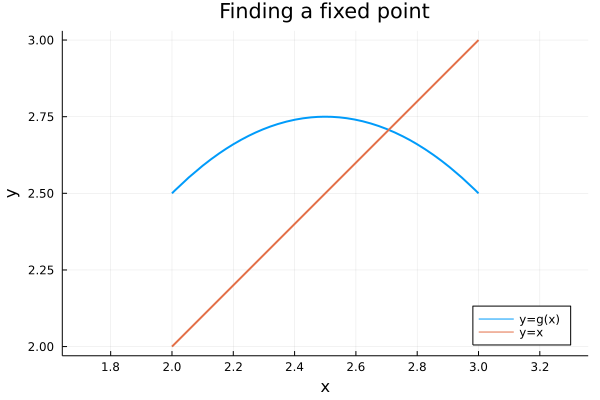

In [57]:
plt = plot([g x->x],2,3,l=2,label=["y=g(x)" "y=x"], xlabel="x", ylabel="y", aspect_ratio=1,title="Finding a fixed point", legend=:bottomright)

In [58]:
x = 2.1;
y = g(x)

2.59

. . .

$x = 2.1$ is not a fixed-point, but $y = g(x)$ is much closer to the fixed-point near 2.7 than $x$!  Let's take this as our next $x$ value.

---

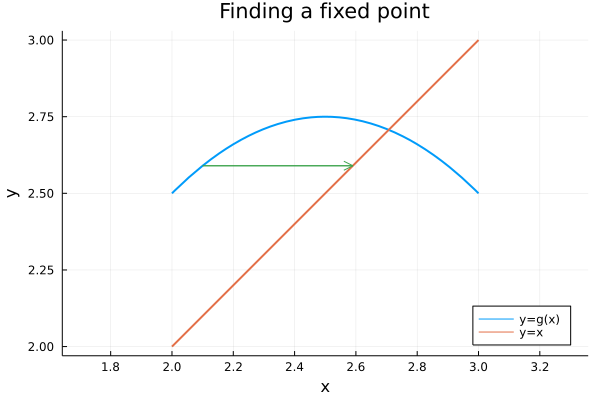

In [59]:
plot!([x,y],[y,y],arrow=true,color=3,label="")

. . .

Now, we compute another new $x$ value by calculating $y = g(x)$ and taking this as our new $x$ value.

---

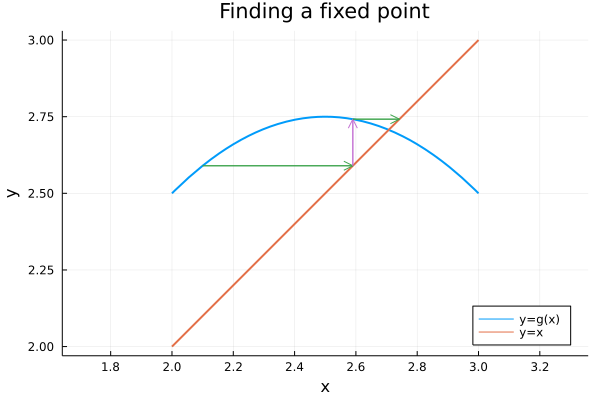

In [60]:
x = y; y = g(x)
plot!([x,x],[x,y], arrow=true, color = 4,label="")
plot!([x,y],[y,y], arrow=true, color = 3,label="")

. . .

We can repeat this a few times to see what happens!

---

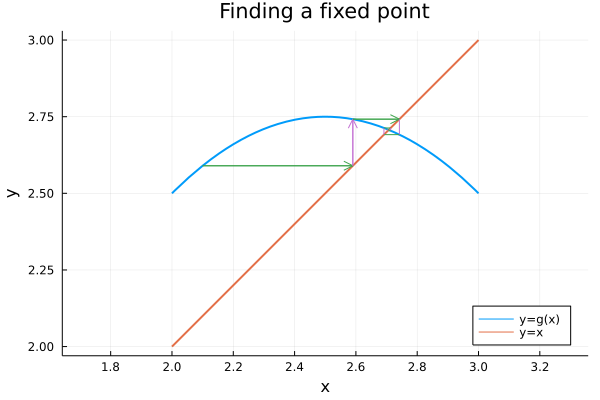

In [61]:
for k = 1:5
    x = y
    y = g(x)
    plot!([x,x],[x,y],color=4,label="");
    plot!([x,y],[y,y],color=3,label="")
end
plt

. . .

Let's measure the error in our current approximation of the fixed-point!

In [62]:
abs(y-rmax)/rmax

0.0001653094344995643

. . .

Now, let's try to find the other fixed point near $1.29$ using this method.

---

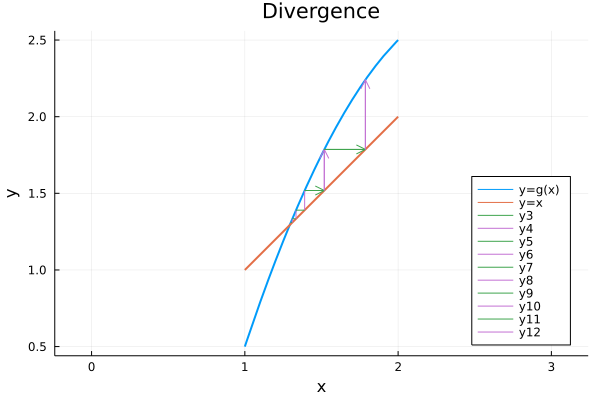

In [64]:
plt = plot([g x->x],1,2,l=2,label=["y=g(x)" "y=x"],aspect_ratio=1,xlabel="x",ylabel="y",title="Divergence",legend=:bottomright)

x = 1.3; y=g(x);
arrow=false
for k = 1:5
    plot!([x,y],[y,y],arrow=arrow,color=3)
    x = y
    y = g(x)
    plot!([x,x],[x,y],arrow=arrow,color=4)
    if k>2; arrow=true; end
end
plt

. . .

This time the fixed-point iterative method is making worse and worse approximations to the fixed-point that are moving away from the solution.  

. . .

What do you notice that is different in this case?

## Series analysis

Suppose fixed-point $p$ is the desired limit of an iteration $x_1, x_2, \cdots$.  Consider the error sequence $\epsilon_1, \epsilon_2, \cdots$ where $\epsilon_k := x_k - p$.  

. . .

By the definition of the iteration, we have $$\epsilon_{k+1} + p = g(\epsilon_k + p) = g(p) + g'(p)\epsilon_k + \frac12 g''(p) \epsilon_k^2 + \cdots,$$ assuming that $g$ has at least two continuous derivatives.

. . .

Since $g(p) = p$, we have $$\epsilon_{k+1} = g'(p)\epsilon_k + O(\epsilon_k^2).$$  

---

Now, if the iteration is to converge to $p$, we must have the errors converging to $0$.  If this is the case, we can neglect the second quadratic term and conclude that $\epsilon_{k+1} \approx g'(p) \epsilon_k$.  This will be convergent if $|g'(p)| < 1$, but we see that the errors must grow (and not vanish) if $|g'(p)| >1$.

. . .

::: {.callout-warning icon=false}
## Fact: 
Fixed-point iteration for a differentiable $g(x)$ converges to a fixed point $p$ if the initial error is sufficiently small and $|g'(p)| < 1$.  The iteration diverges for all initial values if $|g'(p)| > 1$.
:::

. . .

In our previous example, we have $g(x) = x - (x^2 - 4x + 3.5) = -x^2 + 5x - 3.5$ and $g'(x) = -2x + 5$.  Near $p = 2.71$ (the convergent fixed point), we have $g'(p) \approx - 0.42$, indicating convergence.  Near $p = 1.29$ (the divergent fixed point), we get $g'(p) \approx 2.42$ which is consistent with the observed divergence.

## Linear convergence

Our prediction of the convergence of the error, given our work above, is that the errors will approximately satisfy $$|\epsilon_{k+1}| = \sigma |\epsilon_k|$$ for $\sigma = |g'(p)| < 1$.  This is known as **linear convergence**.

::: {.callout-note icon=false}
## Definition: Linear convergence
Suppose a sequence $x_k$ approaches limit $x^*$.  If the error sequence $\epsilon_k = x_k - x^*$ satisfies $$\lim_{k \rightarrow \infty} \frac{|\epsilon_{k+1}|}{|\epsilon_k|} = \sigma < 1,$$ then the sequence $x_k$ displays **linear convergence**.  The number $\sigma$ is called the **convergence rate**.
:::

---

In [65]:
g = x -> x - f(x)
x = [2.1]
for k = 1:12
    push!(x, g(x[k]))
end
x

13-element Vector{Float64}:
 2.1
 2.59
 2.7419000000000002
 2.69148439
 2.713333728386328
 2.7044887203327885
 2.7081843632566587
 2.7066592708954196
 2.7072919457529734
 2.7070300492259465
 2.707138558717502
 2.707093617492436
 2.7071122335938966

---

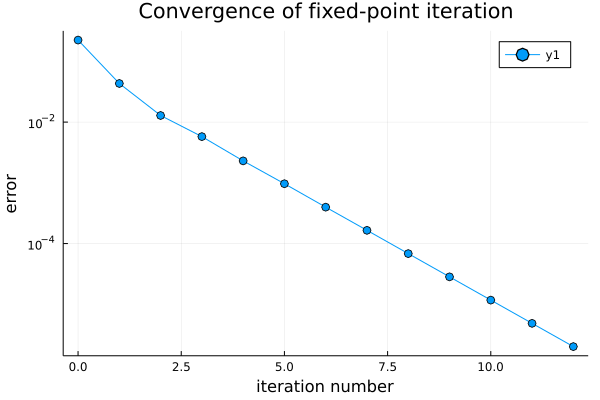

In [67]:
err = @. abs(x - rmax)/rmax

plot(0:12,err,m=:o, xaxis="iteration number",yaxis=("error",:log10),title="Convergence of fixed-point iteration")

. . .

::: {.callout-warning icon=false}
## Fact: Linear convergence in practice
When graphed on a log-linear scale, the errors lie on a straight line whose slope is the log of the convergence rate.  This phenomena (and the reduction of error scaling with $\sigma$) manifest most strongly at later iterations.
:::

---

In [68]:
y = log.(err[5:12])
p = Polynomials.fit(5:12,y,1)   #fit a linear function to the logarithm of the error sequence (i.e., fit to the data in the previous plot)
sig = exp(p.coeffs[2])

0.41448513854854707

In [69]:
[ err[i+1]/err[i] for i in 8:11 ]

4-element Vector{Float64}:
 0.41376605208171086
 0.4143987269383
 0.4141368304124451
 0.4142453399049934

These agree well!

## Contraction maps

::: {.callout-note icon=false}
## Definition: Lipschitz condition
A function $g$ is said to satisfy a **Lipschitz condition** with constant $L$ on the interval $S \subset \mathbb{R}$ if, for all $s,t \in S$, $$|g(s) - g(t)| \le L |s-t|.$$
:::

. . .

A function satisfying a Lipschitz condition (for any $L$) is known to be continuous on $S$.  Do you see why?

---

If $L < 1$, we call $g$ a **contraction mapping** because applying $g$ decreases distances between points.

::: {.callout-warning icon=false}
## Theorem: Contraction mapping
Suppose $g$ satisfies a Lipschitz condition with $L < 1$ on an interval $S$.  Then $S$ contains exactly one fixed point $p$ of $g$.  If $x_1, x_2, \cdots$ are generated by the fixed point iteration defined by $g$ and $x_1, x_2, \cdots$ all lie within $S$, then $$|x_k - p| \le L^{k-1} |x_1 - p|$$ for all $k > 1$.
:::

. . .

::: {.callout-warning icon=false}
## Corollary: 
If $|g'(x)| \le L < 1$ for all $x$ in an interval $S$, then $S$ contains exactly one fixed point $p$ of $g$.  If $x_1, x_2, \cdots$ are generated by the fixed point iteration defined by $g$ and $x_1, x_2, \cdots$ all lie within $S$, then $$|x_k - p| \le L^{k-1} |x_1 - p|$$ for all $k > 1$. 
:::

<!--
[verbose test]{.content-hidden when-format="revealjs" when-format="pptx"}

::: {.callout-caution icon=false}
## Exercise: 

:::

<details><summary>Answer:</summary> </details>


::: {.callout-note icon=false}
## Definition: 
 
:::


::: {.callout-tip icon=false}
## Note: 
 
:::
-->